In [1]:
import os.path as osp
import pickle
import random

import numpy as np
import torch

import lmdb

import numpy as np
from torch.utils.data import Dataset
import torchvision
import kornia
from skimage.color import lab2rgb


from collections import OrderedDict
import os.path as osp

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel


from scipy import signal


In [2]:


def register(model, dummy_input_list):
    # reset params
    global registered_hooks, model_info_lst
    registered_hooks, model_info_lst = [], []

    # register hook
    model.apply(register_hook)

    # forward
    with torch.no_grad():
        model.eval()
        out = model(*dummy_input_list)

    # remove hooks
    for hook in registered_hooks:
        hook.remove()

    return out


def parse_model_info(model):
    tot_gflops = 0
    for module_info in model_info_lst:
        if module_info['gflops']:
            tot_gflops += module_info['gflops']

    tot_params = 0
    for param in model.parameters():
        tot_params += torch.prod(torch.tensor(param.size())).item()

    return tot_gflops, tot_params

In [3]:
def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """

    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

In [4]:
class BaseDataset(Dataset):
    def __init__(self, data_opt, **kwargs):
        # dict to attr
        for kw, args in data_opt.__dict__.items():
            setattr(self, kw, args)


    def __len__(self):
        pass

    def __getitem__(self, item):
        pass

   
    @staticmethod
    def init_lmdb(seq_dir):
        env = lmdb.open(
            seq_dir, readonly=True, lock=False, readahead=False, meminit=False)
        return env

    @staticmethod
    def parse_lmdb_key(key):
        key_lst = key.split('_')
        idx, size, frm = key_lst[:-2], key_lst[-2], int(key_lst[-1])
        idx = '_'.join(idx)
        size = tuple(map(int, size.split('x')))  # n_frm, h, w
        return idx, size, frm

    @staticmethod
    def read_lmdb_frame(env, key, size):
        with env.begin(write=False) as txn:
            buf = txn.get(key.encode('ascii'))
        frm = np.frombuffer(buf, dtype=np.uint8).reshape(*size)
        return frm

    def crop_sequence(self, **kwargs):
        pass

    @staticmethod
    def augment_sequence(**kwargs):
        pass

In [5]:
class PairedLMDBDataset(BaseDataset):
    """ LMDB dataset for paired data (for BI degradation)
    """

    def __init__(self, data_opt, **kwargs):
        super(PairedLMDBDataset, self).__init__(data_opt, **kwargs)
        
        self.lr_seq_dir = data_opt.lr_seq_dir
        self.data_type = data_opt.data_type
        self.scale = data_opt.scale
        self.tempo_extent = data_opt.tempo_extent
        self.moving_first_frame = data_opt.moving_first_frame
        self.moving_factor = data_opt.moving_factor
        self.filter_file = data_opt.filter_file
        
        self.transform = torchvision.transforms.Compose([torchvision.transforms.Resize((256, 256))])

        # load meta info
        lr_meta = pickle.load(
            open(osp.join(self.lr_seq_dir, 'meta_info.pkl'), 'rb'))
        self.lr_keys = sorted(lr_meta['keys'])
        
        # register parameters
        self.lr_env = None

    def __len__(self):
        return len(self.lr_keys)

    def __getitem__(self, item):
        if self.lr_env is None:
            self.lr_env = self.init_lmdb(self.lr_seq_dir)

        # parse info
        lr_key = self.lr_keys[item]
        idx, (tot_frm, lr_h, lr_w), cur_frm = self.parse_lmdb_key(lr_key)

        c = 3 if self.data_type.lower() == 'rgb' else 1
        
        # get frames
        lr_frms = []
        if self.moving_first_frame and (random.uniform(0, 1) > self.moving_factor):
            # load the first gt&lr frame
            lr_frm = self.read_lmdb_frame(
                self.lr_env, lr_key, size=(lr_h, lr_w, c))
            lr_frm = lr_frm.transpose(2, 0, 1)  # chw|rgb|uint8

            # generate random moving parameters
            offsets = np.floor(
                np.random.uniform(-1.5, 1.5, size=(self.tempo_extent, 2)))
            offsets = offsets.astype(np.int32)
            pos = np.cumsum(offsets, axis=0)
            min_pos = np.min(pos, axis=0)
            topleft_pos = pos - min_pos
            range_pos = np.max(pos, axis=0) - min_pos
            c_h, c_w = lr_h - range_pos[0], lr_w - range_pos[1]

            # generate frames
            for i in range(self.tempo_extent):
                lr_top, lr_left = topleft_pos[i]
                lr_frms.append(lr_frm[
                    :, lr_top: lr_top + c_h, lr_left: lr_left + c_w].copy())

        else:
            # read frames
            for i in range(cur_frm, cur_frm + self.tempo_extent):
                if i >= tot_frm:
                    # reflect temporal paddding, e.g., (0,1,2) -> (0,1,2,1,0)
                    lr_key = '{}_{}x{}x{}_{:04d}'.format(
                        idx, tot_frm, lr_h, lr_w, 2 * tot_frm - i - 2)
                else:
                    lr_key = '{}_{}x{}x{}_{:04d}'.format(
                        idx, tot_frm, lr_h, lr_w, i)

                lr_frm = self.read_lmdb_frame(
                    self.lr_env, lr_key, size=(lr_h, lr_w, c))
                lr_frm = lr_frm.transpose(2, 0, 1)
                lr_frms.append(lr_frm)

        lr_frms = np.stack(lr_frms)
        lr_tsr = torch.FloatTensor(np.ascontiguousarray(lr_frms)) / 255
        lr_tsr = self.transform(lr_tsr)

        lr_tsr = kornia.color.rgb_to_lab(lr_tsr)
        L = lr_tsr[:, 0:1, :, :]
        ab = lr_tsr[:, 1:, :, :]
        
        L = L/ 50. - 1. # Between -1 and 1
        ab = ab / 110. # Between -1 and 1
        
        return {'L': L, 'ab': ab}

 
    @staticmethod
    def augment_sequence(gt_pats, lr_pats):
        # flip
        axis = random.randint(1, 3)
        if axis > 1:
            gt_pats = np.flip(gt_pats, axis)
            lr_pats = np.flip(lr_pats, axis)

        # rotate 90 degree
        k = random.randint(0, 3)
        gt_pats = np.rot90(gt_pats, k, (2, 3))
        lr_pats = np.rot90(lr_pats, k, (2, 3))

        return gt_pats, lr_pats
    


In [6]:
class DatasetConfig:
    def __init__(self, 
                 lr_seq_dir,
                 data_type='rgb',
                 scale=1,
                 tempo_extent=5,
                 moving_first_frame=False,
                 moving_factor=0.5,
                 filter_file=None):
        self.lr_seq_dir = lr_seq_dir
        self.data_type = data_type
        self.scale = scale
        self.tempo_extent = tempo_extent
        self.moving_first_frame = moving_first_frame
        self.moving_factor = moving_factor
        self.filter_file = filter_file

data_opt = DatasetConfig(
    lr_seq_dir='/media/moose/Moose/Dataset/AMD/',
    data_type='rgb',
    scale=1,
    tempo_extent=10,
    moving_first_frame=False,
    moving_factor=0.5,
    filter_file=None
)


In [7]:
ds = PairedLMDBDataset(data_opt)

FileNotFoundError: [Errno 2] No such file or directory: '/media/moose/Moose/Dataset/AMD/meta_info.pkl'

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
L=ds[40]['L']
ab=ds[40]['ab']


/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
L.shape

torch.Size([10, 1, 256, 256])

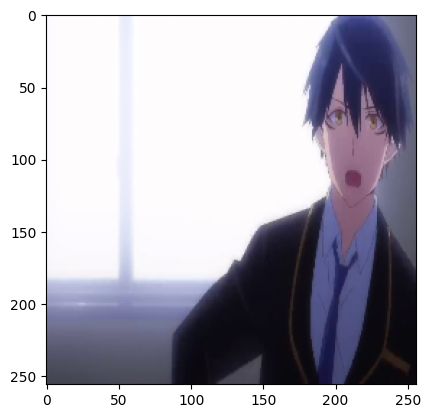

In [ ]:
plt.imshow(lab_to_rgb(L,ab)[0])

### Models

In [ ]:
import functools

def create_kernel(sigma, ksize=None):
    if ksize is None:
        ksize = 1 + 2 * int(sigma * 3.0)

    gkern1d = signal.gaussian(ksize, std=sigma).reshape(ksize, 1)
    gkern2d = np.outer(gkern1d, gkern1d)
    gaussian_kernel = gkern2d / gkern2d.sum()
    zero_kernel = np.zeros_like(gaussian_kernel)

    kernel = np.float32([
        [gaussian_kernel, zero_kernel, zero_kernel],
        [zero_kernel, gaussian_kernel, zero_kernel],
        [zero_kernel, zero_kernel, gaussian_kernel]])

    kernel = torch.from_numpy(kernel)

    return kernel


def downsample_bd(data, kernel, scale, pad_data):
    """
        Note:
            1. `data` should be torch.FloatTensor (data range 0~1) in shape [nchw]
            2. `pad_data` should be enabled in model testing
            3. This function is device agnostic, i.e., data/kernel could be on cpu or gpu
    """

    if pad_data:
        # compute padding params
        kernel_h, kernel_w = kernel.shape[-2:]
        pad_h, pad_w = kernel_h - 1, kernel_w - 1
        pad_t = pad_h // 2
        pad_b = pad_h - pad_t
        pad_l = pad_w // 2
        pad_r = pad_w - pad_l

        # pad data
        data = F.pad(data, (pad_l, pad_r, pad_t, pad_b), 'reflect')

    # blur + down sample
    data = F.conv2d(data, kernel, stride=scale, bias=None, padding=0)

    return data



def get_dist_info():
    """ Adopted from BasicSR
    """
    if dist.is_available():
        initialized = dist.is_initialized()
    else:
        initialized = False

    if initialized:
        rank = dist.get_rank()
        world_size = dist.get_world_size()
    else:
        rank = 0
        world_size = 1

    return rank, world_size


def master_only(func):
    """ Adopted from BasicSR
    """
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        rank, _ = get_dist_info()
        if rank == 0:
            return func(*args, **kwargs)

    return wrapper

In [ ]:
class BaseModel():
    def __init__(self, opt):
        self.opt = opt
        self.scale = opt['scale']
        self.device = torch.device(opt['device'])
        self.blur_kernel = None
        self.dist = opt['dist']
        self.is_train = opt['is_train']

        if self.is_train:
            self.lr_data, self.gt_data = None, None
            self.ckpt_dir = opt['train']['ckpt_dir']
            self.log_decay = opt['logger'].get('decay', 0.99)
            self.log_dict = OrderedDict()
            self.running_log_dict = OrderedDict()

    def set_networks(self):
        pass

    def set_criterions(self):
        pass

    def set_optimizers(self):
        pass

    def set_lr_schedules(self):
        pass

    def prepare_training_data(self, data):
        """ prepare gt, lr data for training

            for BD degradation, generate lr data and remove the border of gt data
            for BI degradation, use input data directly
        """

        degradation_type = self.opt['dataset']['degradation']['type']

        if degradation_type == 'BI':
            self.gt_data = data['gt'].to(self.device)
            self.lr_data = data['lr'].to(self.device)

        elif degradation_type == 'BD':
            # generate lr data on the fly (on gpu)

            # set params
            scale = self.opt['scale']
            sigma = self.opt['dataset']['degradation'].get('sigma', 1.5)
            border_size = int(sigma * 3.0)

            gt_data = data['gt'].to(self.device)  # with border
            n, t, c, gt_h, gt_w = gt_data.size()
            lr_h = (gt_h - 2*border_size)//scale
            lr_w = (gt_w - 2*border_size)//scale

            # create blurring kernel
            if self.blur_kernel is None:
                self.blur_kernel = create_kernel(sigma).to(self.device)
            blur_kernel = self.blur_kernel

            # generate lr data
            gt_data = gt_data.view(n*t, c, gt_h, gt_w)
            lr_data = downsample_bd(gt_data, blur_kernel, scale, pad_data=False)
            lr_data = lr_data.view(n, t, c, lr_h, lr_w)

            # remove gt border
            gt_data = gt_data[
                ...,
                border_size: border_size + scale*lr_h,
                border_size: border_size + scale*lr_w]
            gt_data = gt_data.view(n, t, c, scale*lr_h, scale*lr_w)

            self.gt_data, self.lr_data = gt_data, lr_data  # tchw|float32

    def prepare_inference_data(self, data):
        """ Prepare lr data for training (w/o loading on device)
        """

        degradation_type = self.opt['dataset']['degradation']['type']

        if degradation_type == 'BI':
            self.lr_data = data['lr']

        elif degradation_type == 'BD':
            if 'lr' in data:
                self.lr_data = data['lr']
            else:
                # generate lr data on the fly (on cpu)
                # TODO: do frame-wise downsampling on gpu for acceleration?
                gt_data = data['gt']  # thwc|uint8

                # set params
                scale = self.opt['scale']
                sigma = self.opt['dataset']['degradation'].get('sigma', 1.5)

                # create blurring kernel
                if self.blur_kernel is None:
                    self.blur_kernel = create_kernel(sigma)
                blur_kernel = self.blur_kernel.cpu()

                # generate lr data
                gt_data = gt_data.permute(0, 3, 1, 2).float()  / 255.0  # tchw|float32
                lr_data = downsample_bd(
                    gt_data, blur_kernel, scale, pad_data=True)
                lr_data = lr_data.permute(0, 2, 3, 1)  # thwc|float32

                self.lr_data = lr_data

        # thwc to tchw
        self.lr_data = self.lr_data.permute(0, 3, 1, 2)  # tchw|float32

    def train(self):
        pass

    def infer(self):
        pass

    def model_to_device(self, net):
        net = net.to(self.device)
        if self.dist:
            net = nn.SyncBatchNorm.convert_sync_batchnorm(net)
            net = DistributedDataParallel(
                net, device_ids=[torch.cuda.current_device()])
        return net

    def update_learning_rate(self):
        if hasattr(self, 'sched_G') and self.sched_G is not None:
            self.sched_G.step()

        if hasattr(self, 'sched_D') and self.sched_D is not None:
            self.sched_D.step()

    def get_learning_rate(self):
        lr_dict = OrderedDict()

        if hasattr(self, 'optim_G'):
            lr_dict['lr_G'] = self.optim_G.param_groups[0]['lr']

        if hasattr(self, 'optim_D'):
            lr_dict['lr_D'] = self.optim_D.param_groups[0]['lr']

        return lr_dict

    def reduce_log(self):
        if self.dist:
            rank, world_size = self.opt['rank'], self.opt['world_size']
            with torch.no_grad():
                keys, vals = [], []
                for key, val in self.log_dict.items():
                    keys.append(key)
                    vals.append(val)
                vals = torch.FloatTensor(vals).to(self.device)
                dist.reduce(vals, dst=0)
                if rank == 0:  # average
                    vals /= world_size
                self.log_dict = {key: val.item() for key, val in zip(keys, vals)}

    def update_running_log(self):
        self.reduce_log()  # for distributed training

        d = self.log_decay
        for k in self.log_dict.keys():
            current_val = self.log_dict[k]
            running_val = self.running_log_dict.get(k)

            if running_val is None:
                running_val = current_val
            else:
                running_val = d * running_val + (1.0 - d) * current_val

            self.running_log_dict[k] = running_val

    def get_current_log(self):
        return self.log_dict

    def get_running_log(self):
        return self.running_log_dict

    def get_format_msg(self, epoch, iter):
        # generic info
        msg = f'[epoch: {epoch} | iter: {iter}'
        for lr_type, lr in self.get_learning_rate().items():
            msg += f' | {lr_type}: {lr:.2e}'
        msg += '] '

        # loss info
        log_dict = self.get_running_log()
        msg += ', '.join([f'{k}: {v:.3e}' for k, v in log_dict.items()])

        return msg

    def save(self, current_iter):
        pass

    @staticmethod
    def get_bare_model(net):
        if isinstance(net, DistributedDataParallel):
            net = net.module
        return net

    @master_only
    def save_network(self, net, net_label, current_iter):
        filename = f'{net_label}_iter{current_iter}.pth'
        save_path = osp.join(self.ckpt_dir, filename)
        net = self.get_bare_model(net)
        torch.save(net.state_dict(), save_path)

    def save_training_state(self, current_epoch, current_iter):
        # TODO
        pass

    def load_network(self, net, load_path):
        state_dict = torch.load(
            load_path, map_location=lambda storage, loc: storage)
        net = self.get_bare_model(net)
        net.load_state_dict(state_dict)

    def pad_sequence(self, lr_data):
        """
            Parameters:
                :param lr_data: tensor in shape tchw
        """
        padding_mode = self.opt['test'].get('padding_mode', 'reflect')
        n_pad_front = self.opt['test'].get('num_pad_front', 0)
        assert n_pad_front < lr_data.size(0)

        # pad
        if padding_mode == 'reflect':
            lr_data = torch.cat(
                [lr_data[1: 1 + n_pad_front, ...].flip(0), lr_data], dim=0)

        elif padding_mode == 'replicate':
            lr_data = torch.cat(
                [lr_data[:1, ...].expand(n_pad_front, -1, -1, -1), lr_data], dim=0)

        else:
            raise ValueError(f'Unrecognized padding mode: {padding_mode}')

        return lr_data, n_pad_front


In [ ]:
class BaseModel():
    def __init__(self, opt):
        self.opt = opt
        self.scale = opt['scale']
        self.device = torch.device(opt['device'])
        self.blur_kernel = None
        self.dist = opt['dist']
        self.is_train = opt['is_train']

        if self.is_train:
            self.lr_data, self.gt_data = None, None
            self.ckpt_dir = opt['train']['ckpt_dir']
            self.log_decay = opt['logger'].get('decay', 0.99)
            self.log_dict = OrderedDict()
            self.running_log_dict = OrderedDict()

    def set_networks(self):
        pass

    def set_criterions(self):
        pass

    def set_optimizers(self):
        pass

    def set_lr_schedules(self):
        pass

    def prepare_training_data(self, data):
        """ prepare gt, lr data for training

            for BD degradation, generate lr data and remove the border of gt data
            for BI degradation, use input data directly
        """

        degradation_type = self.opt['dataset']['degradation']['type']

        if degradation_type == 'BI':
            self.gt_data = data['gt'].to(self.device)
            self.lr_data = data['lr'].to(self.device)

        elif degradation_type == 'BD':
            # generate lr data on the fly (on gpu)

            # set params
            scale = self.opt['scale']
            sigma = self.opt['dataset']['degradation'].get('sigma', 1.5)
            border_size = int(sigma * 3.0)

            gt_data = data['gt'].to(self.device)  # with border
            n, t, c, gt_h, gt_w = gt_data.size()
            lr_h = (gt_h - 2*border_size)//scale
            lr_w = (gt_w - 2*border_size)//scale

            # create blurring kernel
            if self.blur_kernel is None:
                self.blur_kernel = create_kernel(sigma).to(self.device)
            blur_kernel = self.blur_kernel

            # generate lr data
            gt_data = gt_data.view(n*t, c, gt_h, gt_w)
            lr_data = downsample_bd(gt_data, blur_kernel, scale, pad_data=False)
            lr_data = lr_data.view(n, t, c, lr_h, lr_w)

            # remove gt border
            gt_data = gt_data[
                ...,
                border_size: border_size + scale*lr_h,
                border_size: border_size + scale*lr_w]
            gt_data = gt_data.view(n, t, c, scale*lr_h, scale*lr_w)

            self.gt_data, self.lr_data = gt_data, lr_data  # tchw|float32

    def prepare_inference_data(self, data):
        """ Prepare lr data for training (w/o loading on device)
        """

        degradation_type = self.opt['dataset']['degradation']['type']

        if degradation_type == 'BI':
            self.lr_data = data['lr']

        elif degradation_type == 'BD':
            if 'lr' in data:
                self.lr_data = data['lr']
            else:
                # generate lr data on the fly (on cpu)
                # TODO: do frame-wise downsampling on gpu for acceleration?
                gt_data = data['gt']  # thwc|uint8

                # set params
                scale = self.opt['scale']
                sigma = self.opt['dataset']['degradation'].get('sigma', 1.5)

                # create blurring kernel
                if self.blur_kernel is None:
                    self.blur_kernel = create_kernel(sigma)
                blur_kernel = self.blur_kernel.cpu()

                # generate lr data
                gt_data = gt_data.permute(0, 3, 1, 2).float()  / 255.0  # tchw|float32
                lr_data = downsample_bd(
                    gt_data, blur_kernel, scale, pad_data=True)
                lr_data = lr_data.permute(0, 2, 3, 1)  # thwc|float32

                self.lr_data = lr_data

        # thwc to tchw
        self.lr_data = self.lr_data.permute(0, 3, 1, 2)  # tchw|float32

    def train(self):
        pass

    def infer(self):
        pass

    def model_to_device(self, net):
        net = net.to(self.device)
        if self.dist:
            net = nn.SyncBatchNorm.convert_sync_batchnorm(net)
            net = DistributedDataParallel(
                net, device_ids=[torch.cuda.current_device()])
        return net

    def update_learning_rate(self):
        if hasattr(self, 'sched_G') and self.sched_G is not None:
            self.sched_G.step()

        if hasattr(self, 'sched_D') and self.sched_D is not None:
            self.sched_D.step()

    def get_learning_rate(self):
        lr_dict = OrderedDict()

        if hasattr(self, 'optim_G'):
            lr_dict['lr_G'] = self.optim_G.param_groups[0]['lr']

        if hasattr(self, 'optim_D'):
            lr_dict['lr_D'] = self.optim_D.param_groups[0]['lr']

        return lr_dict

    def reduce_log(self):
        if self.dist:
            rank, world_size = self.opt['rank'], self.opt['world_size']
            with torch.no_grad():
                keys, vals = [], []
                for key, val in self.log_dict.items():
                    keys.append(key)
                    vals.append(val)
                vals = torch.FloatTensor(vals).to(self.device)
                dist.reduce(vals, dst=0)
                if rank == 0:  # average
                    vals /= world_size
                self.log_dict = {key: val.item() for key, val in zip(keys, vals)}

    def update_running_log(self):
        self.reduce_log()  # for distributed training

        d = self.log_decay
        for k in self.log_dict.keys():
            current_val = self.log_dict[k]
            running_val = self.running_log_dict.get(k)

            if running_val is None:
                running_val = current_val
            else:
                running_val = d * running_val + (1.0 - d) * current_val

            self.running_log_dict[k] = running_val

    def get_current_log(self):
        return self.log_dict

    def get_running_log(self):
        return self.running_log_dict

    def get_format_msg(self, epoch, iter):
        # generic info
        msg = f'[epoch: {epoch} | iter: {iter}'
        for lr_type, lr in self.get_learning_rate().items():
            msg += f' | {lr_type}: {lr:.2e}'
        msg += '] '

        # loss info
        log_dict = self.get_running_log()
        msg += ', '.join([f'{k}: {v:.3e}' for k, v in log_dict.items()])

        return msg

    def save(self, current_iter):
        pass

    @staticmethod
    def get_bare_model(net):
        if isinstance(net, DistributedDataParallel):
            net = net.module
        return net

    @master_only
    def save_network(self, net, net_label, current_iter):
        filename = f'{net_label}_iter{current_iter}.pth'
        save_path = osp.join(self.ckpt_dir, filename)
        net = self.get_bare_model(net)
        torch.save(net.state_dict(), save_path)

    def save_training_state(self, current_epoch, current_iter):
        # TODO
        pass

    def load_network(self, net, load_path):
        state_dict = torch.load(
            load_path, map_location=lambda storage, loc: storage)
        net = self.get_bare_model(net)
        net.load_state_dict(state_dict)

    def pad_sequence(self, lr_data):
        """
            Parameters:
                :param lr_data: tensor in shape tchw
        """
        padding_mode = self.opt['test'].get('padding_mode', 'reflect')
        n_pad_front = self.opt['test'].get('num_pad_front', 0)
        assert n_pad_front < lr_data.size(0)

        # pad
        if padding_mode == 'reflect':
            lr_data = torch.cat(
                [lr_data[1: 1 + n_pad_front, ...].flip(0), lr_data], dim=0)

        elif padding_mode == 'replicate':
            lr_data = torch.cat(
                [lr_data[:1, ...].expand(n_pad_front, -1, -1, -1), lr_data], dim=0)

        else:
            raise ValueError(f'Unrecognized padding mode: {padding_mode}')

        return lr_data, n_pad_front


In [ ]:


# ===----------------- utility functions -------------------- #
def initialize_weights(net_l, init_type='kaiming', scale=1):
    """ Modify from BasicSR/MMSR
    """

    if not isinstance(net_l, list):
        net_l = [net_l]

    for net in net_l:
        for m in net.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
                if init_type == 'xavier':
                    nn.init.xavier_uniform_(m.weight)
                elif init_type == 'kaiming':
                    nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in')
                else:
                    raise NotImplementedError(init_type)

                m.weight.data *= scale  # to stabilize training

                if m.bias is not None:
                    nn.init.constant_(m.bias.data, 0)

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight.data, 1)
                nn.init.constant_(m.bias.data, 0)


def space_to_depth(x, scale):
    """ Equivalent to tf.space_to_depth()
    """

    n, c, in_h, in_w = x.size()
    out_h, out_w = in_h // scale, in_w // scale

    x_reshaped = x.reshape(n, c, out_h, scale, out_w, scale)
    x_reshaped = x_reshaped.permute(0, 3, 5, 1, 2, 4)
    output = x_reshaped.reshape(n, scale * scale * c, out_h, out_w)

    return output


def backward_warp(x, flow, mode='bilinear', padding_mode='border'):
    """ Backward warp `x` according to `flow`

        Both x and flow are pytorch tensor in shape `nchw` and `n2hw`

        Reference:
            https://github.com/sniklaus/pytorch-spynet/blob/master/run.py#L41
    """

    n, c, h, w = x.size()

    # create mesh grid
    iu = torch.linspace(-1.0, 1.0, w).view(1, 1, 1, w).expand(n, -1, h, -1)
    iv = torch.linspace(-1.0, 1.0, h).view(1, 1, h, 1).expand(n, -1, -1, w)
    grid = torch.cat([iu, iv], 1).to(flow.device)

    # normalize flow to [-1, 1]
    flow = torch.cat([
        flow[:, 0:1, ...] / ((w - 1.0) / 2.0),
        flow[:, 1:2, ...] / ((h - 1.0) / 2.0)], dim=1)

    # add flow to grid and reshape to nhw2
    grid = (grid + flow).permute(0, 2, 3, 1)

    # bilinear sampling
    # Note: `align_corners` is set to `True` by default for PyTorch version < 1.4.0
    if int(''.join(torch.__version__.split('.')[:2])) >= 14:
        output = F.grid_sample(
            x, grid, mode=mode, padding_mode=padding_mode, align_corners=True)
    else:
        output = F.grid_sample(x, grid, mode=mode, padding_mode=padding_mode)

    return output


def get_upsampling_func(scale=4, degradation='BI'):
    if degradation == 'BI':
        upsample_func = functools.partial(
            F.interpolate, scale_factor=scale, mode='bilinear',
            align_corners=False)

    elif degradation == 'BD':
        upsample_func = BicubicUpsampler(scale_factor=scale)

    else:
        raise ValueError(f'Unrecognized degradation type: {degradation}')

    return upsample_func


# --------------------- utility classes --------------------- #
class BicubicUpsampler(nn.Module):
    """ Bicubic upsampling function with similar behavior to that in TecoGAN-Tensorflow

        Note:
            This function is different from torch.nn.functional.interpolate and matlab's imresize
            in terms of the bicubic kernel and the sampling strategy

        References:
            http://verona.fi-p.unam.mx/boris/practicas/CubConvInterp.pdf
            https://stackoverflow.com/questions/26823140/imresize-trying-to-understand-the-bicubic-interpolation
    """

    def __init__(self, scale_factor, a=-0.75):
        super(BicubicUpsampler, self).__init__()

        # calculate weights (according to Eq.(6) in the reference paper)
        cubic = torch.FloatTensor([
            [0, a, -2*a, a],
            [1, 0, -(a + 3), a + 2],
            [0, -a, (2*a + 3), -(a + 2)],
            [0, 0, a, -a]
        ])

        kernels = [
            torch.matmul(cubic, torch.FloatTensor([1, s, s**2, s**3]))
            for s in [1.0*d/scale_factor for d in range(scale_factor)]
        ]  # s = x - floor(x)

        # register parameters
        self.scale_factor = scale_factor
        self.register_buffer('kernels', torch.stack(kernels))  # size: (f, 4)

    def forward(self, input):
        n, c, h, w = input.size()
        f = self.scale_factor

        # merge n&c
        input = input.reshape(n*c, 1, h, w)

        # pad input (left, right, top, bottom)
        input = F.pad(input, (1, 2, 1, 2), mode='replicate')

        # calculate output (vertical expansion)
        kernel_h = self.kernels.view(f, 1, 4, 1)
        output = F.conv2d(input, kernel_h, stride=1, padding=0)
        output = output.permute(0, 2, 1, 3).reshape(n*c, 1, f*h, w + 3)

        # calculate output (horizontal expansion)
        kernel_w = self.kernels.view(f, 1, 1, 4)
        output = F.conv2d(output, kernel_w, stride=1, padding=0)
        output = output.permute(0, 2, 3, 1).reshape(n*c, 1, f*h, f*w)

        # split n&c
        output = output.reshape(n, c, f*h, f*w)

        return output

In [ ]:
class BaseSequenceGenerator(nn.Module):
    def __init__(self):
        super(BaseSequenceGenerator, self).__init__()

    def generate_dummy_data(self, lr_size):
        """ Generate random input tensors for function `step`
        """
        return None

    def profile(self, *args, **kwargs):
        pass

    def forward(self, *args, **kwargs):
        """ Interface (support DDP)
        """
        pass

    def forward_sequence(self, lr_data):
        """ Forward a whole sequence (for training)
        """
        pass

    def step(self, *args, **kwargs):
        """ Forward a single frame
        """
        pass

    def infer_sequence(self, lr_data, device):
        """ Infer a whole sequence (for inference)
        """
        pass


class BaseSequenceDiscriminator(nn.Module):
    def __init__(self):
        super(BaseSequenceDiscriminator, self).__init__()

    def forward(self, *args, **kwargs):
        """ Interface (support DDP)
        """
        pass

    def step(self, *args, **kwargs):
        """ Forward a singe frame
        """
        pass

    def forward_sequence(self, data, args_dict):
        """ Forward a whole sequence (for training)
        """
        pass

In [ ]:

class VGGFeatureExtractor(nn.Module):
    def __init__(self, feature_indexs=(8, 17, 26, 35)):
        super(VGGFeatureExtractor, self).__init__()

        # init feature layers
        self.features = torchvision.models.vgg19(pretrained=True).features
        for param in self.features.parameters():
            param.requires_grad = False

        # Notes:
        # 1. default feature layers are 8(conv2_2), 17(conv3_4), 26(conv4_4),
        #    35(conv5_4)
        # 2. features are extracted after ReLU activation
        self.feature_indexs = sorted(feature_indexs)

        # register normalization params
        mean = torch.FloatTensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)  # RGB
        std  = torch.FloatTensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
        self.register_buffer('mean', mean)
        self.register_buffer('std', std)

    def forward(self, x):
        # assume input ranges in [0, 1]
        out = (x - self.mean) / self.std

        feature_list = []
        for i in range(len(self.features)):
            out = self.features[i](out)
            if i in self.feature_indexs:
                # clone to prevent overlapping by inplaced ReLU
                feature_list.append(out.clone())

        return feature_list

In [ ]:
def float32_to_uint8(inputs):
    """ Convert np.float32 array to np.uint8

        Parameters:
            :param input: np.float32, (NT)CHW, [0, 1]
            :return: np.uint8, (NT)CHW, [0, 255]
    """
    return np.uint8(np.clip(np.round(inputs * 255), 0, 255))


In [ ]:

# ====================== generator modules ====================== #
class FNet(nn.Module):
    """ Optical flow estimation network
    """

    def __init__(self, in_nc):
        super(FNet, self).__init__()

        self.encoder1 = nn.Sequential(
            nn.Conv2d(2*in_nc, 32, 3, 1, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 32, 3, 1, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, 2))

        self.encoder2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, 3, 1, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, 2))

        self.encoder3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 128, 3, 1, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, 2))

        self.decoder1 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 256, 3, 1, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True))

        self.decoder2 = nn.Sequential(
            nn.Conv2d(256, 128, 3, 1, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 128, 3, 1, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True))

        self.decoder3 = nn.Sequential(
            nn.Conv2d(128, 64, 3, 1, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, 3, 1, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True))

        self.flow = nn.Sequential(
            nn.Conv2d(64, 32, 3, 1, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 2, 3, 1, 1, bias=True))

    def forward(self, x1, x2):
        """ Compute optical flow from x1 to x2
        """

        out = self.encoder1(torch.cat([x1, x2], dim=1))
        out = self.encoder2(out)
        out = self.encoder3(out)
        out = F.interpolate(
            self.decoder1(out), scale_factor=2, mode='bilinear', align_corners=False)
        out = F.interpolate(
            self.decoder2(out), scale_factor=2, mode='bilinear', align_corners=False)
        out = F.interpolate(
            self.decoder3(out), scale_factor=2, mode='bilinear', align_corners=False)
        out = torch.tanh(self.flow(out)) * 24  # 24 is the max velocity

        return out


class ResidualBlock(nn.Module):
    """ Residual block without batch normalization
    """

    def __init__(self, nf=64):
        super(ResidualBlock, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(nf, nf, 3, 1, 1, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(nf, nf, 3, 1, 1, bias=True))

    def forward(self, x):
        out = self.conv(x) + x

        return out


class SRNet(nn.Module):
    """ Reconstruction & Upsampling network
    """

    def __init__(self, in_nc, out_nc, nf, nb, upsample_func, scale):
        super(SRNet, self).__init__()

        # input conv.
        self.conv_in = nn.Sequential(
            nn.Conv2d((scale**2 + 1) * in_nc, nf, 3, 1, 1, bias=True),
            nn.ReLU(inplace=True))

        # residual blocks
        self.resblocks = nn.Sequential(*[ResidualBlock(nf) for _ in range(nb)])

        # upsampling blocks
        conv_up = [
            nn.ConvTranspose2d(nf, nf, 3, 2, 1, output_padding=1, bias=True),
            nn.ReLU(inplace=True)]

        if scale == 4:
            conv_up += [
                nn.ConvTranspose2d(nf, nf, 3, 2, 1, output_padding=1, bias=True),
                nn.ReLU(inplace=True)]

        self.conv_up = nn.Sequential(*conv_up)

        # output conv.
        self.conv_out = nn.Conv2d(nf, out_nc, 3, 1, 1, bias=True)

        # upsampling function
        self.upsample_func = upsample_func

    def forward(self, lr_curr, hr_prev_tran):
        """ lr_curr: the current lr data in shape nchw
            hr_prev_tran: the previous transformed hr_data in shape n(s*s*c)hw
        """

        out = self.conv_in(torch.cat([lr_curr, hr_prev_tran], dim=1))
        out = self.resblocks(out)
        out = self.conv_up(out)
        out = self.conv_out(out)
        out += self.upsample_func(lr_curr)

        return out


class FRNet(BaseSequenceGenerator):
    """ Frame-recurrent network: https://arxiv.org/abs/1801.04590
    """

    def __init__(self, in_nc, out_nc, nf, nb, degradation, scale):
        super(FRNet, self).__init__()

        self.scale = scale

        # get upsampling function according to degradation type
        self.upsample_func = get_upsampling_func(self.scale, degradation)

        # define fnet & srnet
        self.fnet = FNet(in_nc)
        self.srnet = SRNet(in_nc, out_nc, nf, nb, self.upsample_func, self.scale)

    def forward(self, lr_data, device=None):
        if self.training:
            out = self.forward_sequence(lr_data)
        else:
            out = self.infer_sequence(lr_data, device)

        return out

    def forward_sequence(self, lr_data):
        """
            Parameters:
                :param lr_data: lr data in shape ntchw
        """

        n, t, c, lr_h, lr_w = lr_data.size()
        hr_h, hr_w = lr_h * self.scale, lr_w * self.scale

        # calculate optical flows
        lr_prev = lr_data[:, :-1, ...].reshape(n * (t - 1), c, lr_h, lr_w)
        lr_curr = lr_data[:, 1:, ...].reshape(n * (t - 1), c, lr_h, lr_w)
        lr_flow = self.fnet(lr_curr, lr_prev)  # n*(t-1),2,h,w

        # upsample lr flows
        hr_flow = self.scale * self.upsample_func(lr_flow)
        hr_flow = hr_flow.view(n, (t - 1), 2, hr_h, hr_w)

        # compute the first hr data
        hr_data = []
        hr_prev = self.srnet(
            lr_data[:, 0, ...],
            torch.zeros(n, (self.scale**2)*c, lr_h, lr_w, dtype=torch.float32,
                        device=lr_data.device))
        hr_data.append(hr_prev)

        # compute the remaining hr data
        for i in range(1, t):
            # warp hr_prev
            hr_prev_warp = backward_warp(hr_prev, hr_flow[:, i - 1, ...])

            # compute hr_curr
            hr_curr = self.srnet(
                lr_data[:, i, ...],
                space_to_depth(hr_prev_warp, self.scale))

            # save and update
            hr_data.append(hr_curr)
            hr_prev = hr_curr

        hr_data = torch.stack(hr_data, dim=1)  # n,t,c,hr_h,hr_w

        # construct output dict
        ret_dict = {
            'hr_data': hr_data,  # n,t,c,hr_h,hr_w
            'hr_flow': hr_flow,  # n,t,2,hr_h,hr_w
            'lr_prev': lr_prev,  # n(t-1),c,lr_h,lr_w
            'lr_curr': lr_curr,  # n(t-1),c,lr_h,lr_w
            'lr_flow': lr_flow,  # n(t-1),2,lr_h,lr_w
        }

        return ret_dict

    def step(self, lr_curr, lr_prev, hr_prev):
        """
            Parameters:
                :param lr_curr: the current lr data in shape nchw
                :param lr_prev: the previous lr data in shape nchw
                :param hr_prev: the previous hr data in shape nc(sh)(sw)
        """

        # estimate lr flow (lr_curr -> lr_prev)
        lr_flow = self.fnet(lr_curr, lr_prev)

        # pad if size is not a multiple of 8
        pad_h = lr_curr.size(2) - lr_curr.size(2)//8*8
        pad_w = lr_curr.size(3) - lr_curr.size(3)//8*8
        lr_flow_pad = F.pad(lr_flow, (0, pad_w, 0, pad_h), 'reflect')

        # upsample lr flow
        hr_flow = self.scale * self.upsample_func(lr_flow_pad)

        # warp hr_prev
        hr_prev_warp = backward_warp(hr_prev, hr_flow)

        # compute hr_curr
        hr_curr = self.srnet(lr_curr, space_to_depth(hr_prev_warp, self.scale))

        return hr_curr

    def infer_sequence(self, lr_data, device):
        """
            Parameters:
                :param lr_data: torch.FloatTensor in shape tchw
                :param device: torch.device

                :return hr_seq: uint8 np.ndarray in shape tchw
        """

        # set params
        tot_frm, c, h, w = lr_data.size()
        s = self.scale

        # forward
        hr_seq = []
        lr_prev = torch.zeros(1, c, h, w, dtype=torch.float32).to(device)
        hr_prev = torch.zeros(1, c, s*h, s*w, dtype=torch.float32).to(device)

        with torch.no_grad():
            for i in range(tot_frm):
                lr_curr = lr_data[i: i + 1, ...].to(device)
                hr_curr = self.step(lr_curr, lr_prev, hr_prev)
                lr_prev, hr_prev = lr_curr, hr_curr

                hr_frm = hr_curr.squeeze(0).cpu().numpy()  # chw|rgb|uint8
                hr_seq.append(float32_to_uint8(hr_frm))

        return np.stack(hr_seq).transpose(0, 2, 3, 1)  # thwc

    def generate_dummy_data(self, lr_size, device):
        c, lr_h, lr_w = lr_size
        s = self.scale

        # generate dummy input data
        lr_curr = torch.rand(1, c, lr_h, lr_w, dtype=torch.float32).to(device)
        lr_prev = torch.rand(1, c, lr_h, lr_w, dtype=torch.float32).to(device)
        hr_prev = torch.rand(1, c, s*lr_h, s*lr_w, dtype=torch.float32).to(device)

        data_list = [lr_curr, lr_prev, hr_prev]
        return data_list

    def profile(self, lr_size, device):
        gflops_dict, params_dict = OrderedDict(), OrderedDict()

        # generate dummy input data
        lr_curr, lr_prev, hr_prev = self.generate_dummy_data(lr_size, device)

        # profile module 1: flow estimation module
        lr_flow = register(self.fnet, [lr_curr, lr_prev])
        gflops_dict['FNet'], params_dict['FNet'] = parse_model_info(self.fnet)

        # profile module 2: sr module
        pad_h = lr_curr.size(2) - lr_curr.size(2)//8*8
        pad_w = lr_curr.size(3) - lr_curr.size(3)//8*8
        lr_flow_pad = F.pad(lr_flow, (0, pad_w, 0, pad_h), 'reflect')
        hr_flow = self.scale * self.upsample_func(lr_flow_pad)
        hr_prev_warp = backward_warp(hr_prev, hr_flow)
        _ = register(self.srnet, [lr_curr, space_to_depth(hr_prev_warp, self.scale)])
        gflops_dict['SRNet'], params_dict['SRNet'] = parse_model_info(self.srnet)

        return gflops_dict, params_dict


# ====================== discriminator modules ====================== #
class DiscriminatorBlocks(nn.Module):
    def __init__(self):
        super(DiscriminatorBlocks, self).__init__()

        self.block1 = nn.Sequential(  # /2
            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.LeakyReLU(0.2, inplace=True))

        self.block2 = nn.Sequential(  # /4
            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.LeakyReLU(0.2, inplace=True))

        self.block3 = nn.Sequential(  # /8
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.LeakyReLU(0.2, inplace=True))

        self.block4 = nn.Sequential(  # /16
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.LeakyReLU(0.2, inplace=True))

    def forward(self, x):
        out1 = self.block1(x)
        out2 = self.block2(out1)
        out3 = self.block3(out2)
        out4 = self.block4(out3)
        feature_list = [out1, out2, out3, out4]

        return out4, feature_list


class SpatioTemporalDiscriminator(BaseSequenceDiscriminator):
    """ Spatio-Temporal discriminator proposed in TecoGAN
    """

    def __init__(self, in_nc, spatial_size, tempo_range, degradation, scale):
        super(SpatioTemporalDiscriminator, self).__init__()

        # basic settings
        mult = 3  # (conditional triplet, input triplet, warped triplet)
        self.spatial_size = spatial_size
        self.tempo_range = tempo_range
        assert self.tempo_range == 3, 'currently only support 3 as tempo_range'
        self.scale = scale

        # input conv.
        self.conv_in = nn.Sequential(
            nn.Conv2d(in_nc*tempo_range*mult, 64, 3, 1, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True))

        # discriminator block
        self.discriminator_block = DiscriminatorBlocks()  # downsample 16x

        # classifier
        self.dense = nn.Linear(256 * spatial_size // 16 * spatial_size // 16, 1)

        # get upsampling function according to degradation type
        self.upsample_func = get_upsampling_func(self.scale, degradation)

    def forward(self, data, args_dict):
        out = self.forward_sequence(data, args_dict)
        return out

    def forward_sequence(self, data, args_dict):
        """
            :param data: should be either hr_data or gt_data
            :param args_dict: a dict including data/config required here
        """

        # === set params === #
        net_G = args_dict['net_G']
        lr_data = args_dict['lr_data']
        bi_data = args_dict['bi_data']
        hr_flow = args_dict['hr_flow']

        n, t, c, lr_h, lr_w = lr_data.size()
        _, _, _, hr_h, hr_w = data.size()

        s_size = self.spatial_size
        t = t // 3 * 3  # discard other frames
        n_clip = n * t // 3  # total number of 3-frame clips in all batches

        c_size = int(s_size * args_dict['crop_border_ratio'])
        n_pad = (s_size - c_size) // 2

        # === compute forward & backward flow === #
        if 'hr_flow_merge' not in args_dict:
            if args_dict['use_pp_crit']:
                hr_flow_bw = hr_flow[:, 0:t:3, ...]  # e.g., frame1 -> frame0
                hr_flow_idle = torch.zeros_like(hr_flow_bw)
                hr_flow_fw = hr_flow.flip(1)[:, 1:t:3, ...]
            else:
                lr_curr = lr_data[:, 1:t:3, ...]
                lr_curr = lr_curr.reshape(n_clip, c, lr_h, lr_w)

                lr_next = lr_data[:, 2:t:3, ...]
                lr_next = lr_next.reshape(n_clip, c, lr_h, lr_w)

                # compute forward flow
                lr_flow_fw = net_G.fnet(lr_curr, lr_next)
                hr_flow_fw = self.scale * self.upsample_func(lr_flow_fw)

                hr_flow_bw = hr_flow[:, 0:t:3, ...]  # e.g., frame1 -> frame0
                hr_flow_idle = torch.zeros_like(hr_flow_bw)  # frame1 -> frame1
                hr_flow_fw = hr_flow_fw.view(n, t // 3, 2, hr_h, hr_w)  # frame1 -> frame2

            # merge bw/idle/fw flows
            hr_flow_merge = torch.stack(
                [hr_flow_bw, hr_flow_idle, hr_flow_fw], dim=2)  # n,t//3,3,2,h,w

            # reshape and stop gradient propagation
            hr_flow_merge = hr_flow_merge.view(n_clip * 3, 2, hr_h, hr_w).detach()

        else:
            # reused data to reduce computations
            hr_flow_merge = args_dict['hr_flow_merge']

        # === build up inputs for D (3 parts) === #
        # part 1: bicubic upsampled data (conditional inputs)
        cond_data = bi_data[:, :t, ...].reshape(n_clip, 3, c, hr_h, hr_w)
        # note: permutation is not necessarily needed here, it's just to keep
        #       the same impl. as TecoGAN-Tensorflow (i.e., rrrgggbbb)
        cond_data = cond_data.permute(0, 2, 1, 3, 4)
        cond_data = cond_data.reshape(n_clip, c * 3, hr_h, hr_w)

        # part 2: original data
        orig_data = data[:, :t, ...].reshape(n_clip, 3, c, hr_h, hr_w)
        orig_data = orig_data.permute(0, 2, 1, 3, 4)
        orig_data = orig_data.reshape(n_clip, c * 3, hr_h, hr_w)

        # part 3: warped data
        warp_data = backward_warp(
            data[:, :t, ...].reshape(n * t, c, hr_h, hr_w), hr_flow_merge)
        warp_data = warp_data.view(n_clip, 3, c, hr_h, hr_w)
        warp_data = warp_data.permute(0, 2, 1, 3, 4)
        warp_data = warp_data.reshape(n_clip, c * 3, hr_h, hr_w)
        # remove border to increase training stability as proposed in TecoGAN
        warp_data = F.pad(
            warp_data[..., n_pad: n_pad + c_size, n_pad: n_pad + c_size],
            (n_pad,) * 4, mode='constant')

        # combine 3 parts together
        input_data = torch.cat([orig_data, warp_data, cond_data], dim=1)

        # === classify === #
        out = self.conv_in(input_data)
        out, feature_list = self.discriminator_block(out)
        out = out.view(out.size(0), -1)
        out = self.dense(out)
        pred = out, feature_list

        # construct output dict (return other data beside pred)
        ret_dict = {
            'hr_flow_merge': hr_flow_merge
        }

        return pred, ret_dict


class SpatialDiscriminator(BaseSequenceDiscriminator):
    """ Spatial discriminator
    """

    def __init__(self, in_nc, spatial_size, use_cond):
        super(SpatialDiscriminator, self).__init__()

        # basic settings
        self.use_cond = use_cond  # whether to use conditional input
        mult = 2 if self.use_cond else 1
        tempo_range = 1

        # input conv
        self.conv_in = nn.Sequential(
            nn.Conv2d(in_nc*tempo_range*mult, 64, 3, 1, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True))

        # discriminator block
        self.discriminator_block = DiscriminatorBlocks()  # /16

        # classifier
        self.dense = nn.Linear(256 * spatial_size // 16 * spatial_size // 16, 1)

    def forward(self, data, args_dict):
        out = self.forward_sequence(data, args_dict)
        return out

    def step(self, x):
        out = self.conv_in(x)
        out, feature_list = self.discriminator_block(out)

        out = out.view(out.size(0), -1)
        out = self.dense(out)

        return out, feature_list

    def forward_sequence(self, data, args_dict):
        # === set params === #
        n, t, c, hr_h, hr_w = data.size()
        data = data.view(n * t, c, hr_h, hr_w)

        # === build up inputs for net_D === #
        if self.use_cond:
            bi_data = args_dict['bi_data'].view(n * t, c, hr_h, hr_w)
            input_data = torch.cat([bi_data, data], dim=1)
        else:
            input_data = data

        # === classify === #
        pred = self.step(input_data)

        # construct output dict (nothing to return)
        ret_dict = {}

        return pred, ret_dict

In [ ]:

def define_generator(opt):
    net_G_opt = opt['model']['generator']

    if net_G_opt['name'].lower() == 'frnet':  # frame-recurrent generator
        net_G = FRNet(
            in_nc=net_G_opt['in_nc'],
            out_nc=net_G_opt['out_nc'],
            nf=net_G_opt['nf'],
            nb=net_G_opt['nb'],
            degradation=opt['dataset']['degradation']['type'],
            scale=opt['scale'])

    else:
        raise ValueError(f'Unrecognized generator: {net_G_opt["name"]}')

    return net_G


def define_discriminator(opt):
    net_D_opt = opt['model']['discriminator']

    if opt['dataset']['degradation']['type'] == 'BD':
        spatial_size = opt['dataset']['train']['crop_size']
    else:  # BI
        spatial_size = opt['dataset']['train']['gt_crop_size']

    if net_D_opt['name'].lower() == 'stnet':  # spatio-temporal discriminator
        net_D = SpatioTemporalDiscriminator(
            in_nc=net_D_opt['in_nc'],
            spatial_size=spatial_size,
            tempo_range=net_D_opt['tempo_range'],
            degradation=opt['dataset']['degradation']['type'],
            scale=opt['scale'])

    elif net_D_opt['name'].lower() == 'snet':  # spatial discriminator
        net_D = SpatialDiscriminator(
            in_nc=net_D_opt['in_nc'],
            spatial_size=spatial_size,
            use_cond=net_D_opt['use_cond'])

    else:
        raise ValueError(f'Unrecognized discriminator: {net_D_opt["name"]}')

    return net_D

In [ ]:
""" Code adopted from BasicSR: https://github.com/xinntao/BasicSR/blob/master/basicsr/models/lr_scheduler.py
"""

import math

from torch.optim.lr_scheduler import _LRScheduler


def get_position_from_periods(iteration, cumulative_period):
    """Get the position from a period list.

    It will return the index of the right-closest number in the period list.
    For example, the cumulative_period = [100, 200, 300, 400],
    if iteration == 50, return 0;
    if iteration == 210, return 2;
    if iteration == 300, return 2.

    Args:
        iteration (int): Current iteration.
        cumulative_period (list[int]): Cumulative period list.

    Returns:
        int: The position of the right-closest number in the period list.
    """
    for i, period in enumerate(cumulative_period):
        if iteration <= period:
            return i


class CosineAnnealingRestartLR(_LRScheduler):
    """ Cosine annealing with restarts learning rate scheme.

    An example of config:
    periods = [10, 10, 10, 10]
    restart_weights = [1, 0.5, 0.5, 0.5]
    eta_min=1e-7

    It has four cycles, each has 10 iterations. At 10th, 20th, 30th, the
    scheduler will restart with the weights in restart_weights.

    Args:
        optimizer (torch.nn.optimizer): Torch optimizer.
        periods (list): Period for each cosine anneling cycle.
        restart_weights (list): Restart weights at each restart iteration.
            Default: [1].
        eta_min (float): The mimimum lr. Default: 0.
        last_epoch (int): Used in _LRScheduler. Default: -1.
    """

    def __init__(self,
                 optimizer,
                 periods,
                 restart_weights=(1, ),
                 eta_min=0,
                 last_epoch=-1):
        self.periods = periods
        self.restart_weights = restart_weights
        self.eta_min = eta_min
        assert (len(self.periods) == len(self.restart_weights)
                ), 'periods and restart_weights should have the same length.'
        self.cumulative_period = [
            sum(self.periods[0:i + 1]) for i in range(0, len(self.periods))
        ]
        super(CosineAnnealingRestartLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        idx = get_position_from_periods(self.last_epoch,
                                        self.cumulative_period)
        current_weight = self.restart_weights[idx]
        nearest_restart = 0 if idx == 0 else self.cumulative_period[idx - 1]
        current_period = self.periods[idx]

        return [
            self.eta_min + current_weight * 0.5 * (base_lr - self.eta_min) *
            (1 + math.cos(math.pi * (
                (self.last_epoch - nearest_restart) / current_period)))
            for base_lr in self.base_lrs
        ]

In [ ]:

class VanillaGANLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super(VanillaGANLoss, self).__init__()
        self.crit = nn.BCEWithLogitsLoss(reduction=reduction)

    def forward(self, input, status):
        target = torch.empty_like(input).fill_(int(status))
        loss = self.crit(input, target)
        return loss


class LSGANLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super(LSGANLoss, self).__init__()
        self.crit = nn.MSELoss(reduction=reduction)

    def forward(self, input, status):
        """
            :param status: boolean, True/False
        """
        target = torch.empty_like(input).fill_(int(status))
        loss = self.crit(input, target)
        return loss


class CharbonnierLoss(nn.Module):
    """ Charbonnier Loss (robust L1)
    """

    def __init__(self, eps=1e-6, reduction='sum'):
        super(CharbonnierLoss, self).__init__()
        self.eps = eps
        self.reduction = reduction

    def forward(self, x, y):
        diff = x - y
        loss = torch.sqrt(diff * diff + self.eps)

        if self.reduction == 'sum':
            loss = torch.sum(loss)
        elif self.reduction == 'mean':
            loss = torch.mean(loss)
        else:
            raise NotImplementedError
        return loss


class CosineSimilarityLoss(nn.Module):
    def __init__(self, eps=1e-8):
        super(CosineSimilarityLoss, self).__init__()
        self.eps = eps

    def forward(self, input, target):
        diff = F.cosine_similarity(input, target, dim=1, eps=self.eps)
        loss = 1.0 - diff.mean()

        return loss
    

def define_criterion(criterion_opt):
    if criterion_opt is None:
        return None

    # parse
    if criterion_opt['type'] == 'MSE':
        criterion = nn.MSELoss(reduction=criterion_opt['reduction'])

    elif criterion_opt['type'] == 'L1':
        criterion = nn.L1Loss(reduction=criterion_opt['reduction'])

    elif criterion_opt['type'] == 'CB':
        criterion = CharbonnierLoss(reduction=criterion_opt['reduction'])

    elif criterion_opt['type'] == 'CosineSimilarity':
        criterion = CosineSimilarityLoss()

    elif criterion_opt['type'] == 'GAN':
        criterion = VanillaGANLoss(reduction=criterion_opt['reduction'])

    elif criterion_opt['type'] == 'LSGAN':
        criterion = LSGANLoss(reduction=criterion_opt['reduction'])

    else:
        raise ValueError(f'Unrecognized criterion: {criterion_opt["type"]}')

    return criterion


def define_lr_schedule(schedule_opt, optimizer):
    if schedule_opt is None:
        return None

    # parse
    if schedule_opt['type'] == 'FixedLR':
        schedule = None

    elif schedule_opt['type'] == 'MultiStepLR':
        schedule = torch.optim.lr_scheduler.MultiStepLR(
            optimizer,
            milestones=schedule_opt['milestones'],
            gamma=schedule_opt['gamma'])

    elif schedule_opt['type'] == 'CosineAnnealingRestartLR':
        schedule = CosineAnnealingRestartLR(
            optimizer,
            periods=schedule_opt['periods'],
            restart_weights=schedule_opt['restart_weights'],
            eta_min=schedule_opt['eta_min'])

    else:
        raise ValueError(f'Unrecognized lr schedule: {schedule_opt["type"]}')

    return schedule

In [ ]:

class VSRModel(BaseModel):
    """ A model wrapper for objective video super-resolution
    """

    def __init__(self, opt):
        super(VSRModel, self).__init__(opt)

        # define network
        self.set_networks()

        # config training
        if self.is_train:
            self.set_criterions()
            self.set_optimizers()
            self.set_lr_schedules()

    def set_networks(self):
        # define generator
        self.net_G = define_generator(self.opt)
        self.net_G = self.model_to_device(self.net_G)
        
        # load generator
        load_path_G = self.opt['model']['generator'].get('load_path')
        if load_path_G is not None:
            self.load_network(self.net_G, load_path_G)

    def set_criterions(self):
        # pixel criterion
        self.pix_crit = define_criterion(
            self.opt['train'].get('pixel_crit'))

        # warping criterion
        self.warp_crit = define_criterion(
            self.opt['train'].get('warping_crit'))

    def set_optimizers(self):
        self.optim_G = torch.optim.Adam(
            self.net_G.parameters(),
            lr=self.opt['train']['generator']['lr'],
            weight_decay=self.opt['train']['generator'].get('weight_decay', 0),
            betas=self.opt['train']['generator'].get('betas', (0.9, 0.999)))

    def set_lr_schedules(self):
        self.sched_G = define_lr_schedule(
            self.opt['train']['generator'].get('lr_schedule'), self.optim_G)

    def train(self):
        # === initialize === #
        self.net_G.train()
        self.optim_G.zero_grad()

        # === forward net_G === #
        net_G_output_dict = self.net_G(self.lr_data)
        self.hr_data = net_G_output_dict['hr_data']

        # === optimize net_G === #
        loss_G = 0
        self.log_dict = OrderedDict()

        # pixel loss
        pix_w = self.opt['train']['pixel_crit'].get('weight', 1.0)
        loss_pix_G = pix_w * self.pix_crit(self.hr_data, self.gt_data)
        loss_G += loss_pix_G
        self.log_dict['l_pix_G'] = loss_pix_G.item()

        # warping loss
        if self.warp_crit is not None:
            # warp lr_prev according to lr_flow
            lr_curr = net_G_output_dict['lr_curr']
            lr_prev = net_G_output_dict['lr_prev']
            lr_flow = net_G_output_dict['lr_flow']
            lr_warp = backward_warp(lr_prev, lr_flow)

            warp_w = self.opt['train']['warping_crit'].get('weight', 1.0)
            loss_warp_G = warp_w * self.warp_crit(lr_warp, lr_curr)
            loss_G += loss_warp_G
            self.log_dict['l_warp_G'] = loss_warp_G.item()

        # optimize
        loss_G.backward()
        self.optim_G.step()

    def infer(self):
        """ Infer the `lr_data` sequence

            :return: np.ndarray sequence in type [uint8] and shape [thwc]
        """

        lr_data = self.lr_data

        # temporal padding
        lr_data, n_pad_front = self.pad_sequence(lr_data)

        # infer
        self.net_G.eval()
        hr_seq = self.net_G(lr_data, self.device)
        hr_seq = hr_seq[n_pad_front:]

        return hr_seq

    def save(self, current_iter):
        self.save_network(self.net_G, 'G', current_iter)


In [ ]:
class VSRGANModel(VSRModel):
    """ A model wrapper for subjective video super-resolution
    """

    def __init__(self, opt):
        super(VSRGANModel, self).__init__(opt)

        if self.is_train:
            self.cnt_upd_D = 0

    def set_networks(self):
        # define generator
        self.net_G = define_generator(self.opt)
        self.net_G = self.model_to_device(self.net_G)
        
        # load generator
        load_path_G = self.opt['model']['generator'].get('load_path', '')
        if load_path_G:
            self.load_network(self.net_G, load_path_G)
        
        if self.is_train:
            # define discriminator
            self.net_D = define_discriminator(self.opt)
            self.net_D = self.model_to_device(self.net_D)
            
            # load discriminator
            load_path_D = self.opt['model']['discriminator'].get('load_path', '')
            if load_path_D:
                self.load_network(self.net_D, load_path_D)

    def set_criterions(self):
        # pixel criterion
        self.pix_crit = define_criterion(self.opt['train'].get('pixel_crit'))

        # warping criterion
        self.warp_crit = define_criterion(self.opt['train'].get('warping_crit'))

        # feature criterion
        self.feat_crit = define_criterion(
            self.opt['train'].get('feature_crit'))
        if self.feat_crit is not None:  # load feature extractor
            feature_layers = self.opt['train']['feature_crit'].get(
                'feature_layers', [8, 17, 26, 35])
            self.net_F = VGGFeatureExtractor(feature_layers).to(self.device)

        # ping-pong criterion
        self.pp_crit = define_criterion(self.opt['train'].get('pingpong_crit'))

        # feature matching criterion
        self.fm_crit = define_criterion(self.opt['train'].get('feature_matching_crit'))

        # gan criterion
        self.gan_crit = define_criterion(self.opt['train'].get('gan_crit'))

    def set_optimizers(self):
        # set optimizer for net_G
        self.optim_G = torch.optim.Adam(
            self.net_G.parameters(),
            lr=self.opt['train']['generator']['lr'],
            weight_decay=self.opt['train']['generator'].get('weight_decay', 0),
            betas=self.opt['train']['generator'].get('betas', (0.9, 0.999)))

        # set optimizer for net_D
        self.optim_D = torch.optim.Adam(
            self.net_D.parameters(),
            lr=self.opt['train']['discriminator']['lr'],
            weight_decay=self.opt['train']['discriminator'].get('weight_decay', 0),
            betas=self.opt['train']['discriminator'].get('betas', (0.9, 0.999)))

    def set_lr_schedules(self):
        # set lr schedules for net_G
        self.sched_G = define_lr_schedule(
            self.opt['train']['generator'].get('lr_schedule'), self.optim_G)

        # set lr schedules for net_D
        self.sched_D = define_lr_schedule(
            self.opt['train']['discriminator'].get('lr_schedule'), self.optim_D)

    def train(self):
        # === prepare data === #
        lr_data, gt_data = self.lr_data, self.gt_data

        n, t, c, lr_h, lr_w = lr_data.size()
        _, _, _, gt_h, gt_w = gt_data.size()

        # generate bicubic upsampled data
        upsample_fn = self.get_bare_model(self.net_G).upsample_func
        bi_data = upsample_fn(
            lr_data.view(n * t, c, lr_h, lr_w)).view(n, t, c, gt_h, gt_w)

        # augment data for pingpong criterion
        # i.e., (0,1,2,...,t-2,t-1) -> (0,1,2,...,t-2,t-1,t-2,...,2,1,0)
        if self.pp_crit is not None:
            lr_rev = lr_data.flip(1)[:, 1:, ...]
            gt_rev = gt_data.flip(1)[:, 1:, ...]
            bi_rev = bi_data.flip(1)[:, 1:, ...]

            lr_data = torch.cat([lr_data, lr_rev], dim=1)
            gt_data = torch.cat([gt_data, gt_rev], dim=1)
            bi_data = torch.cat([bi_data, bi_rev], dim=1)

        # === initialize === #
        self.net_G.train()
        self.net_D.train()
        self.optim_G.zero_grad()
        self.optim_D.zero_grad()
        self.log_dict = OrderedDict()

        # === forward net_G === #
        net_G_output_dict = self.net_G(lr_data)
        hr_data = net_G_output_dict['hr_data']

        # === forward net_D === #
        for param in self.net_D.parameters():
            param.requires_grad = True

        # feed additional data
        net_D_input_dict = {
            'net_G': self.get_bare_model(self.net_G),  # TODO: check
            'lr_data': lr_data,
            'bi_data': bi_data,
            'use_pp_crit': (self.pp_crit is not None),
            'crop_border_ratio': self.opt['train']['discriminator'].get(
                'crop_border_ratio', 1.0)
        }
        net_D_input_dict.update(net_G_output_dict)

        # forward real sequence (gt)
        real_pred, net_D_oputput_dict = self.net_D(gt_data, net_D_input_dict)

        # reuse internal data (e.g., optical flow)
        net_D_input_dict.update(net_D_oputput_dict)

        # forward fake sequence (hr)
        fake_pred, _ = self.net_D(hr_data.detach(), net_D_input_dict)

        # === optimize net_D === #
        real_pred_D, fake_pred_D = real_pred[0], fake_pred[0]

        # select D update policy
        update_policy = self.opt['train']['discriminator']['update_policy']
        if update_policy == 'adaptive':
            # update D adaptively
            logged_real_pred_D = torch.log(torch.sigmoid(real_pred_D) + 1e-8).mean()
            logged_fake_pred_D = torch.log(torch.sigmoid(fake_pred_D) + 1e-8).mean()

            if self.dist:
                # synchronize
                dist.all_reduce(logged_real_pred_D)
                dist.all_reduce(logged_fake_pred_D)
                dist.barrier()

                logged_real_pred_D /= self.opt['world_size']
                logged_fake_pred_D /= self.opt['world_size']

            distance = (logged_real_pred_D - logged_fake_pred_D).item()
            upd_D = distance < self.opt['train']['discriminator']['update_threshold']
        else:
            upd_D = True

        if upd_D:
            self.cnt_upd_D += 1.0
            real_loss_D = self.gan_crit(real_pred_D, True)
            fake_loss_D = self.gan_crit(fake_pred_D, False)
            loss_D = real_loss_D + fake_loss_D

            # update net_D
            loss_D.backward()
            self.optim_D.step()
        else:
            loss_D = torch.zeros(1)

        # logging
        self.log_dict['l_gan_D'] = loss_D.item()
        self.log_dict['p_real_D'] = real_pred_D.mean().item()
        self.log_dict['p_fake_D'] = fake_pred_D.mean().item()
        if update_policy == 'adaptive':
            self.log_dict['distance'] = distance
            self.log_dict['n_upd_D'] = self.cnt_upd_D

        # === optimize net_G === #
        for param in self.net_D.parameters():
            param.requires_grad = False

        # calculate losses
        loss_G = 0

        # pixel (pix) loss
        if self.pix_crit is not None:
            pix_w = self.opt['train']['pixel_crit'].get('weight', 1)
            loss_pix_G = pix_w * self.pix_crit(hr_data, gt_data)
            loss_G += loss_pix_G
            self.log_dict['l_pix_G'] = loss_pix_G.item()

        # warping (warp) loss
        if self.warp_crit is not None:
            lr_curr = net_G_output_dict['lr_curr']
            lr_prev = net_G_output_dict['lr_prev']
            lr_flow = net_G_output_dict['lr_flow']
            lr_warp = backward_warp(lr_prev, lr_flow)

            warp_w = self.opt['train']['warping_crit'].get('weight', 1)
            loss_warp_G = warp_w * self.warp_crit(lr_warp, lr_curr)
            loss_G += loss_warp_G
            self.log_dict['l_warp_G'] = loss_warp_G.item()

        # feature/perceptual (feat) loss
        if self.feat_crit is not None:
            hr_merge = hr_data.view(-1, c, gt_h, gt_w)
            gt_merge = gt_data.view(-1, c, gt_h, gt_w)

            hr_feat_lst = self.net_F(hr_merge)
            gt_feat_lst = self.net_F(gt_merge)

            loss_feat_G = 0
            for hr_feat, gt_feat in zip(hr_feat_lst, gt_feat_lst):
                loss_feat_G += self.feat_crit(hr_feat, gt_feat.detach())

            feat_w = self.opt['train']['feature_crit'].get('weight', 1)
            loss_feat_G = feat_w * loss_feat_G
            loss_G += loss_feat_G
            self.log_dict['l_feat_G'] = loss_feat_G.item()

        # ping-pong (pp) loss
        if self.pp_crit is not None:
            tempo_extent = self.opt['train']['tempo_extent']
            hr_data_fw = hr_data[:, :tempo_extent - 1, ...]      # -------->|
            hr_data_bw = hr_data[:, tempo_extent:, ...].flip(1)  # <--------|

            pp_w = self.opt['train']['pingpong_crit'].get('weight', 1)
            loss_pp_G = pp_w * self.pp_crit(hr_data_fw, hr_data_bw)
            loss_G += loss_pp_G
            self.log_dict['l_pp_G'] = loss_pp_G.item()

        # feature matching (fm) loss
        if self.fm_crit is not None:
            fake_pred, _ = self.net_D(hr_data, net_D_input_dict)
            fake_feat_lst, real_feat_lst = fake_pred[-1], real_pred[-1]

            layer_norm = self.opt['train']['feature_matching_crit'].get(
                'layer_norm', [12.0, 14.0, 24.0, 100.0])

            loss_fm_G = 0
            for i in range(len(real_feat_lst)):
                fake_feat, real_feat = fake_feat_lst[i], real_feat_lst[i]
                loss_fm_G += self.fm_crit(
                    fake_feat, real_feat.detach()) / layer_norm[i]

            fm_w = self.opt['train']['feature_matching_crit'].get('weight', 1)
            loss_fm_G = fm_w * loss_fm_G
            loss_G += loss_fm_G
            self.log_dict['l_fm_G'] = loss_fm_G.item()

        # gan loss
        if self.fm_crit is None:
            fake_pred, _ = self.net_D(hr_data, net_D_input_dict)
        fake_pred_G = fake_pred[0]

        gan_w = self.opt['train']['gan_crit'].get('weight', 1)
        loss_gan_G = gan_w * self.gan_crit(fake_pred_G, True)
        loss_G += loss_gan_G
        self.log_dict['l_gan_G'] = loss_gan_G.item()
        self.log_dict['p_fake_G'] = fake_pred_G.mean().item()

        # update net_G
        loss_G.backward()
        self.optim_G.step()

    def save(self, current_iter):
        self.save_network(self.net_G, 'G', current_iter)
        self.save_network(self.net_D, 'D', current_iter)